In [1]:
%%bash
pip install --upgrade mxnet gluoncv
# optional - for displaying the image in notebook
pip install ipyplot
# After you run this cell, you need to restart
# the notebook

Requirement not upgraded as not directly required: graphviz<0.9.0,>=0.8.1 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from mxnet) (0.8.4)
Requirement not upgraded as not directly required: requests<3,>=2.20.0 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from mxnet) (2.20.0)
Requirement not upgraded as not directly required: matplotlib in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from gluoncv) (3.0.3)
Requirement not upgraded as not directly required: scipy in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from gluoncv) (1.1.0)
Requirement not upgraded as not directly required: Pillow in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from gluoncv) (5.1.0)
Requirement not upgraded as not directly required: urllib3<1.25,>=1.21.1 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from request

amazonei-mxnet 1.5.1 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.18.5 which is incompatible.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
amazonei-mxnet 1.5.1 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.18.5 which is incompatible.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import mxnet as mx
import gluoncv as gcv
# class method for displaying images
import matplotlib.pyplot as plt
gcv.utils.check_version('0.6.0')


In [3]:
#image_url = "https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/mt_baker.jpg"
image_url = "https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg"
image_filepath = 'dog.jpg'
gcv.utils.download(url=image_url, path=image_filepath)

'dog.jpg'

# Visualize image

In [4]:
image = mx.image.image.imread('dog.jpg')
image_orig = image


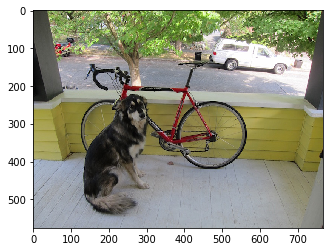

In [5]:
plt.imshow(image.asnumpy())

In [6]:
# this is in HWC layout.
# hieght is first dimenision
# width is the second
# channel is the third
# 
# the values are unsigned 8-bit integers.  The channel is encoded as RGB
print(image[0][0])


[57 58 50]
<NDArray 3 @cpu(0)>


# Need to convert numpy array into form for use with gluon 

The mxnet network expects multiple dimensions as a batch so it needs an extrad dimension.

The error message which arises when this happens  is 

```
 data.ndim() = 4U (3 vs. 4)
 input data should be 4D in batch-num_filter-y-x
```

Array Notes

* y and x = height and width
* N=batch
* C=channel
* H=Height
* W=width

Also,

* gluon expects 32-bit floats
* data is 0-255 unsigned bytes

Data shoukd be avg value 0f zero and standard deviayon of 1

For example `[-1 to 1]`

gluoncv has a transform program for converting it


In [7]:
print('shape: ', image.shape)
print('data types:', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())
# format is HCW

shape:  (576, 768, 3)
data types: <class 'numpy.uint8'>
minimum value: 0
maximum value: 255


# Transform image
A little diffferent from before.  We need to create our own transform since no preset transforms for the data set or the model we will use.
We can compose multiple transforms into a single transform function called transform_fn.  We are using two transforms here. 1. ToTensor and normalize.  They are applied one after another.  Using ToTensor(), the data layer of the image will be converted from HWC to CHW.  The datatype will be converted from an 8-bit image to a 32-bit float.  The normalize() method will normalize the values of the image using the ImageNet one case statistics. 



In [8]:
from mxnet.gluon.data.vision import transforms

transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])


image = transform_fn(image)

In [9]:
print('shape: ', image.shape)
print('data types:', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

shape:  (3, 576, 768)
data types: <class 'numpy.float32'>
minimum value: -2.117904
maximum value: 2.64


# Batch Image


One final step is the create a batch from a single image.  We didn't need to do this in previous lessons because the data set and the model transform presets handles this for us.  Its easy to do by hand because we just need to add an extra dimension to the beginning of our image use the expand_dims() method.  Zero indicates that the new dimension will be added as the first dimension.  You can see the effect by looking at the new image shape.  You should notice the size of the first dimension is one.  Then we have three channels and a heightened width of 567 and 768.

In [10]:
image = image.expand_dims(0)
print(image.shape)

(1, 3, 576, 768)


# Load Model
specify the model name
and specify it as pretrained
The cache will load the model parameters from our earlier run.

Alternatively you can load the model directly

In [11]:
# use yolo3 with darknet backbone trained on the coco dataset.
# our netowrk paramerters are 237 MB and stored in the .mxnet cache
network = gcv.model_zoo.get_model('fcn_resnet50_ade', pretrained=True)

In [12]:
%%bash
ls -ash /home/ec2-user/.mxnet/models/fcn_resnet50_ade*.params

136M /home/ec2-user/.mxnet/models/fcn_resnet50_ade-3479525a.params


# Make prediction
Input was a batch of images.
Output is a single mxnet.ndarray.  This is a batch of predictions.  Since we only had one input image, lets slice off the batch dimension and take only the first prediction.

Now we are elft wih a prediction that has a shape of 150 by 576 by 768 and a data layout of CHW.  We have 150 channels because there are 150 classes in the ADE20K data set that was used for pretraining this model.

You should recognize the last two numbers because they correspond to our images height and width.  

In [13]:
output = network.demo(image)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/gluoncv/model_zoo/segbase.py:102: UserWarning: demo method will be deprecated in favor of predict.
  warnings.warn('demo method will be deprecated in favor of predict.')


In [14]:
# this time prediction is an array
print(type(output))

<class 'mxnet.ndarray.ndarray.NDArray'>


In [15]:
print(output.shape)
output = output[0]
print(output.shape)


(1, 150, 576, 768)
(150, 576, 768)


All of the values in this array are logits, so we still need to process the outputs to obtain probabilities. We don't want to apply the softmax to all of these values at once though. 

We want to do this independently for all pixels so that each pixel has a predicted probability distribution across classes. 

# Closer look: pixel slice

We can jump straight into an example of processing a single pixel, and then see how this can be done for all pixels at once. Will now try to determine the class for random pixels from the image. With our coordinate origin at the top left of the image, let's choose a pixel with the position of 300 along the vertical axis and 500 along the horizontal axis.

Since the output was in CHW format, we can slice using the colon notation at the start to keep all of the output channels for this particular pixel. As mentioned previously, our outputs are currently logits. 



In [16]:
px_height, px_width = 300, 500
px_logit = output[:, px_height, px_width]
print("px_logit = {}".format(px_logit))

px_logit = 
[ 3.53727627e+00  2.63719946e-01  1.26485348e-01  2.65190387e+00
  4.93735028e-03  5.84768057e-01  3.19543171e+00  9.59447622e-01
  2.43332177e-01  2.51652861e+00  1.37785244e+00  1.50629997e+00
  2.43799734e+00  5.36810577e-01  5.46167254e-01  2.41650558e+00
 -7.11230159e-01 -1.12688828e+00 -1.44662690e+00  6.66506588e-01
  2.54120874e+00  2.32127085e-01 -2.56170654e+00 -2.93420768e+00
  1.33695126e+00 -3.01054120e+00 -2.47532177e+00  1.23428571e+00
 -1.33321261e+00 -1.99491954e+00 -1.94125068e+00 -1.77714753e+00
  1.06165588e+00 -1.48882657e-01 -4.88407469e+00 -4.77939844e+00
 -2.65958086e-02  1.45078361e+00  1.59215820e+00 -1.77961719e+00
 -1.36219680e+00  2.44827819e+00 -2.77710509e+00  2.06256318e+00
 -1.46684557e-01 -3.71643996e+00 -1.82021248e+00  1.66682765e-01
 -2.78372502e+00 -1.16084743e+00 -5.96716285e-01 -2.35107112e+00
  2.02040419e-01 -1.67829609e+00 -1.63468525e-01 -3.78150797e+00
  1.08355892e+00 -7.23563552e-01 -1.23275197e+00 -6.42647922e-01
 -1.92101717e

We can use the softmax function to convert the logits to probabilities, and after rounding the results for convenience we can see the probability distribution across classes for this particular pixel. One of the highest probabilities is towards the end with a probability of 96 percent. 

In [17]:
px_probability = mx.nd.softmax(px_logit)
px_rounded_probability = mx.nd.round(px_probability*100)/100
print(px_rounded_probability)


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
<NDArray 150 @cpu(0)>


Using the argmax function we can find the most likely class for this pixel. After converting from an mxnet float to a Python integer, we can say that the class 127 is the most likely. But what is this class? 

In [18]:
class_index = mx.nd.argmax(px_logit, axis=0)
class_index = class_index[0].astype('int').asscalar()
print(class_index)

127


Just as before, we need a lookup table from class indexes to class labels. You can usually find a lookup table on the classes property of a pretrained network, but it's also possible to use the data set directly for this. We import the ADE20K segmentation date set class and use the classes property to find the corresponding class label for our pixel prediction. We find that the most likely class for the selected pixel is bike. We know our image contains a bike near the center. So this seems like a reasonable prediction. 

In [19]:
from gluoncv.data.ade20k.segmentation import ADE20KSegmentation

class_label = ADE20KSegmentation.CLASSES[class_index]
print(class_label)

bicycle, bike, wheel, cycle


We can perform the same analysis for all pixels at once with a minor change in how we use softmax. We've previously been applying softmax across all values. But by specifying axis equals 0, we can apply softmax independently for all pixels. Axis zero corresponds to the channel dimension which are the classes. So the output is a probability distribution across classes for every pixel. 

In [20]:
output_probs = mx.nd.softmax(output, axis=0)

Although we can't easily visualize an image with a 150 channels, we can take a slice across channels this time. Sticking with our predicted class from before, we can slice the 127th channel and obtain an image with the probabilities of each pixel being a bike. We have an obvious cluster of pixels with a very high probability of being a bike. We can see the outline of the bike wheel and the bike frame.

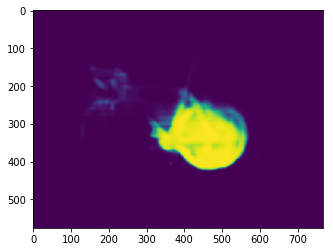

In [21]:
output_heatmap = output_probs[127]
plt.imshow(output_heatmap.asnumpy())

# Visualize most likely class

 We could do the same thing for each class, but with 150 classes, this can be a little overwhelming. A much more useful visualization is to take the most likely class for every pixel. We can use argmax just like before. Our prediction is now a single-channel array with the same height and width, but where all pixel values are class indexes. We could visualize this array directly, but we'd be limited to gray scale colors, and the contrast between classes could be limited.

In [22]:
prediction = mx.nd.argmax(output,0).asnumpy()
print(prediction.shape)
print(prediction)

(576, 768)
[[0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 ...
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]]


 We can instead map each class to a different color in the RGB space, and there are preset mappings for the VOC and ADE20K data sets. Using this mapping, we can clearly see the different segments from our original image. Yellow is used to show regions where the classification is bike for example. 

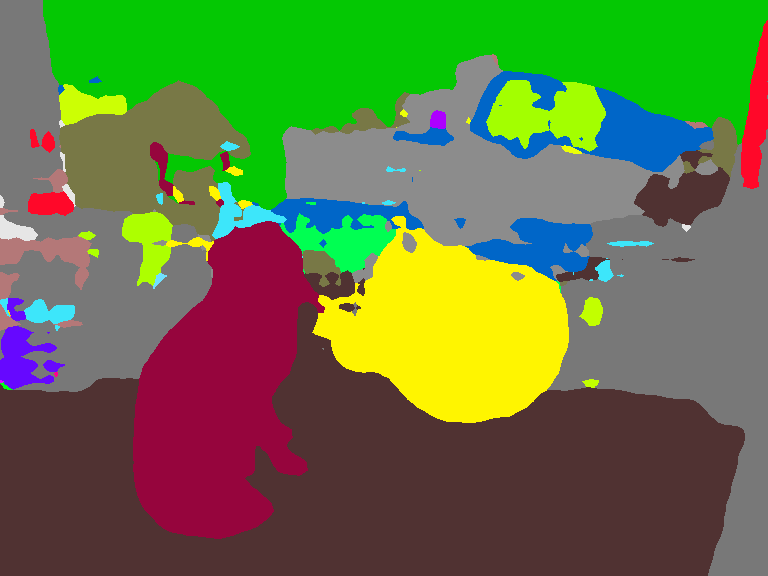

In [23]:
from gluoncv.utils.viz import get_color_pallete

prediction_image = get_color_pallete(prediction, 'ade20k')
prediction_image

For reference. this is the original image

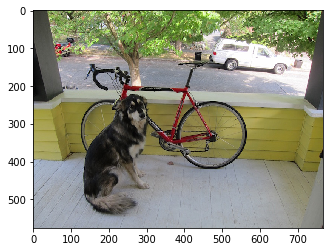

In [24]:
plt.imshow(image_orig.asnumpy())